# EfficientNet with Squeeze Excitation

Our team has developed an enhanced EfficientNetB5-based architecture with two channel wise attention mechanisms

Channel wise attention mechanisms
- Squeeze-and-Excitation (SE) Block
- Channel Attention Block (CA) Block


In this notebook, our team evaluates the performance of this modified EfficientNet model

**This notebook contains the following sections:**
1. Loading Preprocessed Dataset
2. Modified EfficientNet‑B5 model architecture   
3. Hyperparameter Tuning  
4. Model Training
5. Model Evaluation

**Assumed project structure:**
```markdown
ROOT
├── notebooks
│   └── EfficientNetB5.ipynb
└── input
    └── final_split_15Apr2025
        ├── train
        ├── eval
        └── test
* if dataset not downloaded, dataset would download in the loading dataset section.

Configurable Variables:
- **root (str)**: Root directory of the project (commonly set to '..').
- **data_set_directory (str)**: Name of the directory containing all datasets (i.e.,'input')
- **final_data_set (str)**: Folder name of the final processed and augmented dataset used for training.
- **root_result_folder (str)**: Top-level directory name for storing evaluation results.
- **model_directory (str)**: Directory name where all trained models will be saved.
- **google_drive_id (str)**: ID used for Google Drive downloads (if applicable).
- **model_name (str)**: Abbreviation or identifier for the model being trained (used for file naming).
- **batch_size (int)**: Number of samples per training/validation batch.

In [28]:
# Control Panel to adjust variables
root = ".."
data_set_directory = "input"
final_data_set = "final_split_15Apr2025"
root_result_folder = "results"
model_directory = "models" 
google_drive_id = "1XhSO100qgRuLEyopfb7-4gBp0CRjZkfg"

model_name = "ENSE" # Name of the model that the file is training in abbreviation
batch_size = 64 # State the number of datapoints in each batch size

## Imports
Used to handle the imports

In [29]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score


import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# Determine the project root - required to import DataHandler from utils folder
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), root))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

## Loading Dataset and File Location Variables
All code that handles renaming of file location save files

Global Variables Created:
- **PROJECT_ROOT (str)**: Absolute path to the project’s root directory; added to `sys.path` for imports.
- **LOG_DIR (str)**: Path to the directory where log files will be written.
- **ROOT_DATA_DIR (str)**: Path to the directory of the data 
- **MODEL_SAVE_DIR (str)**: Directory for saving model checkpoints and final trained model files.
- **CHECKPOINT_DIR (str)**: Directory where intermediate checkpoints for hyperparameter tuning are stored.
- **RESULTS_DIR (str)**: Path to store evaluation results and metrics, separated by model name.
- **BEST_MODEL_PATH (str)**: Full path to the file where the best-performing model will be saved.
- **DATASET_FOLDER (str)**: Full path to the folder containing the dataset used for training.
- **DEVICE (torch.device)**: The hardware device selected for training ('cuda', 'mps', or 'cpu').

In [30]:
# Configuring log file
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
os.makedirs(LOG_DIR, exist_ok=True)
log_filename = os.path.join(LOG_DIR, F"{model_name}_training_log.txt")
logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)
ROOT_DATA_DIR = os.path.join(root, data_set_directory)

# Creating the models save location
MODEL_SAVE_DIR = os.path.join(PROJECT_ROOT, model_directory, model_name)
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, F"{model_directory}/hyptune/{model_name}")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

RESULTS_DIR = os.path.join(PROJECT_ROOT, F"{root_result_folder}/{model_name}")
print(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

BEST_MODEL_PATH = os.path.join(MODEL_SAVE_DIR, F"{model_name}_best_model.pt")

DATASET_FOLDER = os.path.join(root, data_set_directory,final_data_set)
# Gets the device to be used
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

DEVICE = get_device()

c:\Users\yongl\OneDrive\Documents\GitHub\DogEmotionADL\results/ENSE
Using device: CUDA (GPU)


In [31]:
# Function to download the processed dataset used by the team
download_dataset(final_data_set,f"https://drive.google.com/uc?id={google_drive_id}",  F"{DATASET_FOLDER}.zip", ROOT_DATA_DIR)

Dataset already exists at final_split_15Apr2025


### Loading Dataset

In [32]:
SPLIT_DATASET = os.path.abspath(DATASET_FOLDER)
BATCH_SIZE = batch_size

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

print("LOADING SUBSET DATASET-------------------------------------------------------")
# Creating dataloader to load 50% of the dataset with the same proportions used for hyper parameter tuning
TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

print("LOADING FULL DATASET-------------------------------------------------------")
# Creating dataloader to load the full dataset for training the actual models and testing
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

LOADING SUBSET DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69
LOADING FULL DATASET-------------------------------------------------------
Using pre-split datasets: train 8025, val 579, test 572


## Model Specification
This part of the file will change largely based on each of the models that are being created


In [ ]:
class SqueezeExcitationBlock(nn.Module):
    """
    Squeeze-and-Excitation (SE) block for channel-wise feature recalibration.

    This block implements the SE mechanism which adaptively recalibrates 
    channel-wise feature responses by explicitly modeling interdependencies 
    between channels.

    Args:
        channels (int): Number of input and output channels.
        reduction_ratio (int): Reduction ratio for the intermediate hidden layer. 
            Controls the bottleneck in the SE block (default: 16).

    Forward Input:
        x (Tensor): Input feature map of shape (batch_size, channels, height, width).

    Forward Output:
        Tensor: Output feature map of the same shape, with recalibrated channel responses.
    """

    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ChannelAttentionBlock(nn.Module):
    """
    Channel Attention Block (Lightweight SE-style Attention)

    This module applies channel-wise attention to recalibrate the importance of each feature channel.
    Unlike traditional Squeeze-and-Excitation (SE) blocks that use fully connected (linear) layers,
    this implementation uses 1×1 convolutions for better compatibility with convolutional architectures.

    It compresses spatial dimensions using global average pooling, passes the result through a 
    bottleneck with ReLU activation, and applies a sigmoid gating mechanism to rescale each channel.

    Args:
        in_channels (int): Number of input and output channels in the input feature map.

    Forward Input:
        x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width)

    Forward Output:
        torch.Tensor: Output tensor of the same shape, with recalibrated channel-wise responses.
    """
    def __init__(self, in_channels: int):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Conv2d(in_channels,  in_channels // 16, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(self.avg(x))
        return x * w
    
class SEEfficientNetB5(nn.Module):
    """
    EfficientNetB5-based classifier with optional Squeeze-and-Excitation (SE) block, 
    customizable classifier head, and partial layer unfreezing for fine-tuning.

    Designed for flexibility during hyperparameter tuning (e.g., with Ray Tune).

    Args:
        num_classes (int): Number of output classes. Default is 4.
        dropout (float): Dropout probability used in the classifier head. Default is 0.2.
        hidden_sizes (Optional[List[int]]): List of hidden layer sizes for the classifier head. 
            If None, no additional hidden layers are added beyond the SE block (if used).
        activation (str): Activation function to use in the classifier head. 
            Supported values: 'relu', 'tanh', 'sigmoid'. Default is 'relu'.
        use_se (bool): Whether to include a Squeeze-and-Excitation (SE) block before the classifier. Default is True.
        unfreeze_blocks (Optional[List[int]]): List of block indices in EfficientNetB5's features to unfreeze 
            for fine-tuning. If None, the entire backbone remains frozen.

    Notes:
        - The SE block is applied to the flattened output of the backbone if `use_se` is True.
        - The classifier head is built dynamically based on `hidden_sizes` and activation.
        - The EfficientNetB5 backbone is loaded with pretrained weights by default.
    """
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu',
                 use_se: bool = True,
                 unfreeze_blocks: Optional[List[int]] = None) -> None:
        """
        Initializes an instance of the model with the specified configuration.

        Args:
            num_classes (int, optional): The number of output classes for the model. Default is 4.
            dropout (float, optional): The dropout rate to be applied to the model. Default is 0.2.
            hidden_sizes (List[int], optional): A list specifying the sizes of hidden layers in the model.
                                                If None, the model will use a default configuration. Default is None.
            activation (str, optional): The activation function to use in the model. Default is 'relu'.
                                        Other possible values might include 'sigmoid', 'tanh', etc.
            use_se (bool, optional): Whether or not to use the Squeeze-and-Excitation (SE) block in the model. 
                                        Default is True.
            unfreeze_blocks (List[int], optional): A list of blocks to be unfrozen during training.
                                                    Default is None, which means no blocks are unfrozen.

        """
        super(SEEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features

        # Setting the values layers in the efficientnet backbone that will be frozen
        for param in self.backbone.features.parameters():
            param.requires_grad = False

        if unfreeze_blocks:
            for idx in unfreeze_blocks:
                for param in self.backbone.features[idx].parameters():
                    param.requires_grad = True

        # Build the classifier head with the SE and additional layers according to the number of layers in the hidden state
        layers = []
        if use_se:
            layers.extend([
                nn.Unflatten(1, (in_features, 1, 1)),
                SqueezeExcitationBlock(in_features),
                ChannelAttentionBlock(in_features),
                nn.Flatten()
            ])
        
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
        
        layers.append(nn.Dropout(p=dropout))
        layers.append(nn.Linear(input_dim, num_classes))

        self.backbone.classifier[1] = nn.Sequential(*layers)

    def _get_activation(self, activation: str) -> Callable:
        """
        Returns the specified activation function from PyTorch's nn module.

        Args:
            activation (str): Name of the activation function. Supported values are
                'relu', 'tanh', and 'sigmoid' (case-insensitive).

        Returns:
            Callable: The corresponding activation function module (e.g., nn.ReLU()).

        Raises:
            ValueError: If an unsupported activation function name is provided.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [34]:
print(f"Using device: {DEVICE}")
model = SEEfficientNetB5(num_classes=4, dropout=0.3, hidden_sizes=[256, 128], activation='relu', unfreeze_blocks=[7]).to(DEVICE)
print("Model instantiated:", model.__class__.__name__)
print(model)

Using device: cuda
Model instantiated: BaseEfficientNetB5
BaseEfficientNetB5(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))

## Hyper Parameter Tuning

This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
When there are multiple hyperparameters, this is would be more efficient than grid search and random search.

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.

In [ ]:
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = SEEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu"),
        unfreeze_blocks = config.get("unfreeze_blocks", [7])
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            running_correct += (outputs.argmax(1) == targets).sum().item()  #UPDATE: add this line for accuracy
            running_total   += targets.size(0)  #UPDATE: add this line for accuracy
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        epoch_acc  = running_correct / running_total
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        print(f"[TRAIN] epoch {epoch+1}: loss={epoch_loss:.4f} acc={epoch_acc:.3f}")  #UPDATE: edit this line for accuracy

        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0 #UPDATE: add this line for accuracy
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0) #UPDATE: edit this variable name
            val_correct += (outputs.argmax(1) == targets).sum().item() #UPDATE: add this line for accuracy
            val_total   += targets.size(0) #UPDATE: add this line for accuracy
    
    avg_val_loss = val_loss / val_total
    avg_val_acc  = val_correct / val_total
    print(f"[VAL] loss={avg_val_loss:.4f} acc={avg_val_acc:.3f}") #UPDATE: edit this line for accuracy
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss, "acc": avg_val_acc}) #UPDATE: edit this line for accuracy

In [36]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=2,     # min iterations before stopping
    reduction_factor=2,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format

# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-5, 5e-5),    
    "weight_decay": tune.loguniform(1e-5, 2e-5),
    "dropout": tune.uniform(0.39, 0.41),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu"]), #Removed gelu
    "unfreeze_blocks": tune.choice([[6, 7]]),
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 12, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name=model_name,
        storage_path=F"C:/ray_results/{model_name}", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

# Extracting the best config from the training from above
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

(train_model pid=29412) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29412) Epoch 1/10, Training Loss: 1.3870
(train_model pid=29412) [TRAIN] epoch 1: loss=1.3870 acc=0.256


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29412) Epoch 2/10, Training Loss: 1.3861
(train_model pid=29412) [TRAIN] epoch 2: loss=1.3861 acc=0.259


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29412) Epoch 3/10, Training Loss: 1.3867
(train_model pid=29412) [TRAIN] epoch 3: loss=1.3867 acc=0.248


Epoch 4/10: 100%|██████████| 63/63 [01:28<00:00,  1.41s/it]


(train_model pid=29412) Epoch 4/10, Training Loss: 1.3859
(train_model pid=29412) [TRAIN] epoch 4: loss=1.3859 acc=0.251


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=29412) Epoch 5/10, Training Loss: 1.3864
(train_model pid=29412) [TRAIN] epoch 5: loss=1.3864 acc=0.259


Epoch 6/10:  75%|███████▍  | 47/63 [01:07<00:23,  1.45s/it]
2025-04-22 13:59:32,241	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-04-22 13:59:32,246	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/ENSE/ENSE' in 0.0050s.
Epoch 6/10:  86%|████████▌ | 54/63 [01:17<00:12,  1.42s/it]
2025-04-22 13:59:42,377	INFO tune.py:1041 -- Total run time: 537.92 seconds (527.73 seconds for the tuning loop).
2025-04-22 13:59:42,377	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="C:/ray_results/ENSE/ENSE", trainable=...)
2025-04-22 13:59:42,389	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- t_ad0f8f74: FileNotFoundError('Could not fetch metrics for t_ad0f8f74:

RuntimeError: No best trial found for the given metric: loss. This means that no trial has reported this metric.

## Final Model Training

In [24]:
#### Good configs, saved after various experimentations
# This cell can be skipped if hyper parameter tuning was run
# best_config = {
#     'lr': 2.5883109107619077e-05,
#     'weight_decay': 1.5994372155012393e-05,
#     'dropout': 0.4016587828927856,
#     'hidden_sizes': None,
#     'activation': 'leakyrelu',
#     'unfreeze_blocks': [6, 7],
#     'num_epochs': 10,
#     'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
#     'criterion': lambda: nn.CrossEntropyLoss()
# }
best_config = {
    'lr': 3.667553423789653e-05,
    'weight_decay': 1.8610170848142728e-05,
    'dropout': 0.39636006949943725,
    'hidden_sizes': None, 
    'activation': 'tanh', 
    'unfreeze_blocks': [6, 7], 
    'num_epochs': 10,
    'optimiser': lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
    'criterion': lambda: nn.CrossEntropyLoss()
}


In [ ]:
final_model = SEEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"],
    unfreeze_blocks=best_config["unfreeze_blocks"]
)

optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

final_model = final_model.to(DEVICE)
logging.info("Model instantiated on device: %s", DEVICE)

In [26]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []
train_accs   = [] 
val_accs     = [] 

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        _, predicted = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_correct+= (predicted == targets).sum().item()
        running_total  += targets.size(0)
    epoch_train_loss = running_loss / running_total
    epoch_train_acc  = running_correct / running_total
    train_accs.append(epoch_train_acc)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs, 1)
            running_val_loss += loss.item() * inputs.size(0)
            val_correct     += (predicted == targets).sum().item()
            val_total       += targets.size(0)
    epoch_val_loss = running_val_loss / val_total
    epoch_val_acc  = val_correct / val_total
    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Train Acc={epoch_train_acc:.3f} | Val Loss: {epoch_val_loss:.4f}, Val Acc={epoch_val_acc:.3f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [04:26<00:00,  2.11s/it]


Epoch 1/50 - Train Loss: 1.3086, Train Acc=0.505 | Val Loss: 1.0504, Val Acc=0.686


Epoch 2/50: 100%|██████████| 126/126 [04:58<00:00,  2.37s/it]


Epoch 2/50 - Train Loss: 0.8436, Train Acc=0.711 | Val Loss: 0.7085, Val Acc=0.762


Epoch 3/50: 100%|██████████| 126/126 [07:28<00:00,  3.56s/it]


Epoch 3/50 - Train Loss: 0.5332, Train Acc=0.821 | Val Loss: 0.4646, Val Acc=0.846


Epoch 4/50: 100%|██████████| 126/126 [10:48<00:00,  5.15s/it] 


Epoch 4/50 - Train Loss: 0.3132, Train Acc=0.899 | Val Loss: 0.3801, Val Acc=0.864


Epoch 5/50: 100%|██████████| 126/126 [02:57<00:00,  1.41s/it]


Epoch 5/50 - Train Loss: 0.1788, Train Acc=0.946 | Val Loss: 0.3756, Val Acc=0.879


Epoch 6/50: 100%|██████████| 126/126 [02:42<00:00,  1.29s/it]


Epoch 6/50 - Train Loss: 0.1022, Train Acc=0.974 | Val Loss: 0.3801, Val Acc=0.867


Epoch 7/50: 100%|██████████| 126/126 [02:34<00:00,  1.22s/it]


Epoch 7/50 - Train Loss: 0.0557, Train Acc=0.988 | Val Loss: 0.3713, Val Acc=0.893


Epoch 8/50: 100%|██████████| 126/126 [02:29<00:00,  1.19s/it]


Epoch 8/50 - Train Loss: 0.0392, Train Acc=0.993 | Val Loss: 0.4112, Val Acc=0.891


Epoch 9/50: 100%|██████████| 126/126 [02:38<00:00,  1.26s/it]


Epoch 9/50 - Train Loss: 0.0310, Train Acc=0.995 | Val Loss: 0.4144, Val Acc=0.893


Epoch 10/50: 100%|██████████| 126/126 [02:12<00:00,  1.05s/it]


Epoch 10/50 - Train Loss: 0.0264, Train Acc=0.994 | Val Loss: 0.4615, Val Acc=0.883


Epoch 11/50: 100%|██████████| 126/126 [01:56<00:00,  1.08it/s]


Epoch 11/50 - Train Loss: 0.0240, Train Acc=0.994 | Val Loss: 0.4572, Val Acc=0.883


Epoch 12/50: 100%|██████████| 126/126 [01:52<00:00,  1.12it/s]


Epoch 12/50 - Train Loss: 0.0162, Train Acc=0.997 | Val Loss: 0.4507, Val Acc=0.889
Early stopping triggered.


## Testing

Test Loss: 0.3882, Test Accuracy: 87.94%


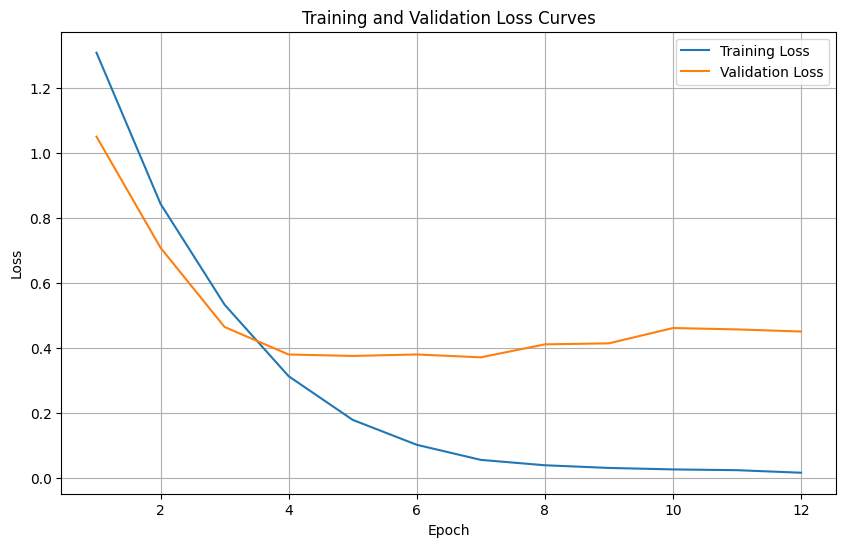

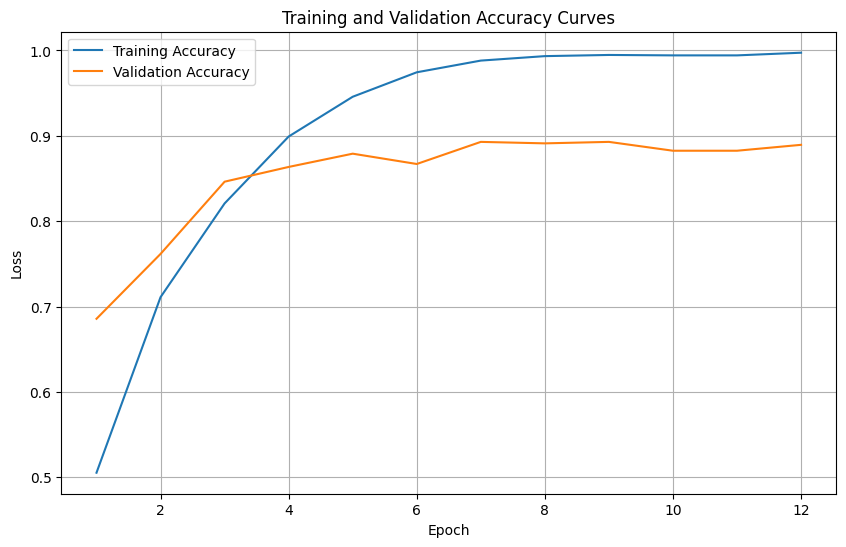


Classification Report:
               precision    recall  f1-score   support

       angry       0.92      0.87      0.89       140
       happy       0.91      0.93      0.92       148
     relaxed       0.84      0.86      0.85       146
         sad       0.85      0.86      0.85       138

    accuracy                           0.88       572
   macro avg       0.88      0.88      0.88       572
weighted avg       0.88      0.88      0.88       572


 F1 score: 0.8790246473485257; 
 Precision score: 0.8796758569571899; 
 Recall Score: 0.878774462797691


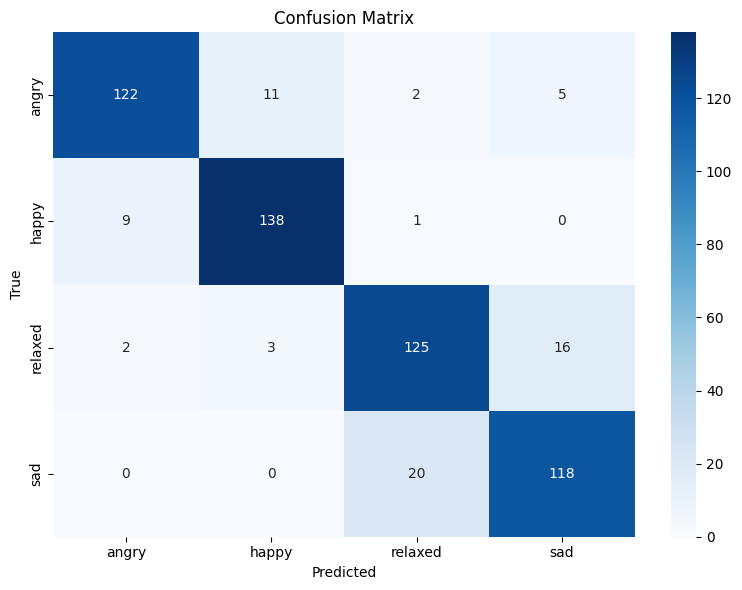

In [27]:
# load best model from training
final_model.load_state_dict(torch.load(BEST_MODEL_PATH))
final_model.to(DEVICE)
final_model.eval()

# initialise metrics
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in FULL_TEST_LOADER:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = final_model(images)
        # for test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        # for accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy()) # move to cpu to ensure compatibility because numpy only operates on cpu
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plotting training and validation loss curves
if 'train_losses' in globals() and 'val_losses' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curves")
    plt.legend()
    plt.grid(True)
    loss_curve_path = os.path.join(RESULTS_DIR, "loss_curves.png") #NOTE: specify by model name
    plt.savefig(loss_curve_path)
    plt.show()
    logging.info("Training and Validation Loss curves saved to %s", loss_curve_path)
else:
    logging.warning("train_losses and val_losses are not defined. Skipping loss curves plot.")

# plotting training and validation acc curves
if 'train_accs' in globals() and 'val_accs' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Training Accuracy")
    plt.plot(range(1, len(val_accs)+1), val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Accuracy Curves")
    plt.legend()
    plt.grid(True)
    acc_curve_path = os.path.join(RESULTS_DIR, "accuracy_curves.png")
    plt.savefig(acc_curve_path)
    plt.show()
    logging.info("Training and Validation Accuracy curves saved to %s", acc_curve_path)
else:
    logging.warning("train_accs and val_accs are not defined. Skipping accuracy curves plot.")

# generate and log classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_labels, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# print f1, precision, recall scores
f1 = f1_score(all_labels, all_preds, average='macro')
prec = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
print(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")
logging.info(f"\n F1 score: {f1}; \n Precision score: {prec}; \n Recall Score: {rec}")

# generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join(RESULTS_DIR, "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.show(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)